In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

## Final consumption

In [2]:
fdata = pd.read_csv('fdata_esp.csv', sep = ',')
fdata.head()
f = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

In [3]:
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f[i],3)
    
print(demand_shock) 
demand_shock = np.array(demand_shock)

[ 0.099  0.086  0.1    0.1    0.1    0.1    0.1    0.1    0.099  0.1
  0.099  0.093  0.099  0.1    0.1    0.1    0.099  0.1    0.1    0.1
  0.099  0.099  0.1    0.008  0.009  0.025  0.099  0.1    0.095  0.095
  0.388  0.275  0.247  0.197  0.022  0.755  0.054  0.038  0.016  0.095
  0.038  0.008  0.019  0.001  0.079  0.093  0.079  0.091  0.035  0.042
  0.007  0.01   0.001  0.043 -0.   ]


## Total output

In [4]:
xdata =  pd.read_csv('xdata_esp.csv', sep = ',')
xdata.head()   
x = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [5]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x[i],6)
    
print(supply_shock) 
supply_shock = np.array(supply_shock)

[0.       0.849999 0.       0.483204 0.259635 0.685309 0.730686 0.
 0.       0.064001 0.525183 0.       0.705058 0.639448 0.726353 0.662572
 0.430758 0.630639 0.618354 0.696668 0.597033 0.596618 0.606449 0.058407
 0.       0.       0.715557 0.27312  0.299699 0.256656 0.       0.
 0.242194 0.       0.       0.646411 0.07561  0.109813 0.       0.144301
 0.       0.       0.       0.512768 0.181406 0.459166 0.410839 0.396788
 0.19581  0.543278 0.       0.460076 0.       0.559507 0.      ]


# IO table 

In [6]:
df = pd.read_csv('esp_wiot.csv',sep = ',',low_memory=False)
df.head()
df = df.iloc[:,1:]# leaving out industries U and T
df = df.astype('float')

In [7]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

## Matrix Z

In [8]:
df_Z = pd.read_csv('esp_Zmatrix.csv', sep=',', low_memory=False)
df_Z =  df_Z.iloc[:,1:]# leaving out industries U and T
df_Z = df_Z.astype('float')
df_Z.shape

(55, 55)

In [9]:
Z = np.array(df_Z)
N = Z.shape[0]
Z.shape

(55, 55)

In [10]:
x_0 = np.array(x)
f_0 = np.array(f)
L = np.linalg.inv(np.identity(N)-A)
L.shape

(55, 55)

# Optimization 

In [11]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return optimal_output, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [12]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

# Rationing

In [13]:
N= 54
f_max = f_max[:N]
x_max = x_max[:N]
A = A[:N,:N]
Z = Z[:N,:N]
x_0 = x_0[:N]
f_0 = f_0[:N]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:N])
demand_shock = np.array(demand_shock[:N])

In [14]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t


In [15]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fout = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        fout.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            denominator = np.matmul(A[i],d[t])
            if denominator == 0:
                r[t][i] = 1 
            else:
                r[t][i] = xmax[i]/denominator
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            fout[t][i] = s[t][i]*d[t][i]
            #print(s[t][i]*d[t][i])
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],fout[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [16]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [17]:
def algo_priority(A, L, fmax, xmax, ordered, TT= 30, prioritize="yes"): 
    fout = [0]                
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        fout.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print(x)
        for i in range(0,N):
            fout[t][i] = s[t][i]*d[t][i]
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],fout[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            #print("Algorithm did not converge")
            return(None, None)
        #print(d[t])
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [34]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    som_x = []
    x = []
    y = []
    TT = 30
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[0] != None:
            som_x.append(result[0])
            #som_x = sum(som_x)/len(sum_x)
            x.append(result[1])
            y.append(result[2])
    return sum(som_x)/len(som_x), sum(x)/len(x), sum(y)/len(y)

# Effect Network Density

In [19]:
N=54
A = np.array(df)[:N,:N]
N = A.shape[0]
A.shape

(54, 54)

In [20]:
Z = np.array(df_Z)[:N,:N]
N = Z.shape[0]
Z.shape

(54, 54)

In [21]:
x_max = np.array(xdata.iloc[:,3].astype('float'))[:N]
x_0 = np.array(x)[:N]
x_0.shape

(54,)

In [22]:
f_max = np.array(fdata.iloc[:,3].astype('float'))[:N]
f_0 = np.array(f)[:N]
f_0.shape

(54,)

In [23]:
L = np.linalg.inv(np.identity(N)-A)
L.shape

(54, 54)

In [24]:
supply_shock = np.zeros(N)
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x[i],6)
    
len(supply_shock) # ok: corresonds to the data 

54

## Eliminate Random Links

In [25]:
from random import randrange
def eliminate_rand(A, x, f, desired_density):
    Anew = A
    zeros = np.sum(Anew==0)
    Znew = Z
    indices_x = []
    indices_y = []
    if desired_density != 1:
        sparselink = round((N**2)*(1-desired_density) - np.sum(Anew==0)) # number of links we need to remove to get desired density
        #print("Sparselink: {0}".format(sparselink))
        while(np.sum(Znew==0)) < sparselink + zeros: 
            random_x = randrange(N)
            random_y = randrange(N)
            while Znew[random_x,random_y] == 0:
                random_x = randrange(N)
                random_y = randrange(N)
            
            Znew[random_x, random_y] = 0
            
            
    xnew = np.sum(Znew, axis=1) + f
    for i in range(0,N):
        for j in range(0,N):
            Anew[i][j] = Znew[i][j]/x[j]
    Lnew = np.linalg.inv(np.identity(N)-Anew)
    
    
    return xnew, Anew, Lnew, Znew

### Direct shock

**For 50 different densities, we adapt our matrix. We compute xnew, Anew, xmaxnew. Then we apply the shocks to the new data: instead of sum(xmax)/sum(x) it is now equal to sum(xmaxnew)/sum(xnew).**

In [26]:
densseq = np.linspace(0,1,50)

In [27]:
resdir_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50

for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        resdir_x[i][j] = (sum(xmaxnew)/sum(newdat[0]))
resdir_x = np.mean(resdir_x, axis = 1)
resdir_x

array([0.63671461, 0.63762599, 0.63875724, 0.63944976, 0.64031042,
       0.64147434, 0.6423761 , 0.64056839, 0.64294558, 0.64402035,
       0.64583908, 0.64503473, 0.64648584, 0.6483508 , 0.64796475,
       0.64877324, 0.64835578, 0.64941244, 0.6503335 , 0.65224681,
       0.65126499, 0.65190523, 0.65350827, 0.65438615, 0.65320383,
       0.65437374, 0.65422524, 0.65736001, 0.65649886, 0.6569623 ,
       0.65738913, 0.6578159 , 0.65873363, 0.65861721, 0.66015044,
       0.65936006, 0.66014726, 0.66195218, 0.66100171, 0.66173531,
       0.6624209 , 0.66365439, 0.66297488, 0.66309584, 0.66359085,
       0.66449323, 0.66451137, 0.66470981, 0.66528185, 0.6655754 ])

## Proportional rationing

In [28]:
resprop_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_proportional(newdat[1], newdat[2], f_max, xmaxnew, TT, prioritize = "no")
        if result[3]!= 30:
            resprop_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprop_x[i][j] = np.nan
resprop_x = np.mean(resprop_x, axis = 1)

## Priority

In [29]:
A = np.array(df)[:N,:N] 
Z = np.array(df_Z)[:N,:N] 
newdat = eliminate_rand(A, x_0, f_0, 0)
xmaxnew = np.ones(N)
for k in range(0,N):
    xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
names_ordered = order(newdat[1],newdat[2],f_max)
        
result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT=30, prioritize="yes")
result[0]/sum(newdat[0])

0.6132727992423517

In [30]:
resprior_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}".format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        names_ordered = order(newdat[1],newdat[2],f_max)
        
        result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT=30, prioritize="yes")
        if result[0] != None:
            resprior_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprior_x[i][j] = np.nan
        
resprior_x = np.nanmean(resprior_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


In [31]:
resprior_x

array([6.13272799e-01, 6.10619645e-01, 6.07552567e-01, 6.01771323e-01,
       5.94546046e-01, 5.98410902e-01, 5.89565184e-01, 5.54647080e-01,
       5.73777488e-01, 5.64284335e-01, 5.54839176e-01, 5.44748008e-01,
       5.34727089e-01, 5.13901145e-01, 4.83978714e-01, 4.79200570e-01,
       4.40879769e-01, 4.33534565e-01, 3.64396663e-01, 3.45881526e-01,
       3.19745495e-01, 3.01012497e-01, 2.13889920e-01, 2.56604092e-01,
       1.78904660e-01, 1.57694250e-01, 1.37166133e-01, 9.42392130e-02,
       7.06992115e-02, 8.36011197e-02, 4.44705969e-02, 3.70595344e-02,
       3.19329207e-02, 1.54433771e-02, 1.07286338e-02, 1.07127745e-02,
       3.56147223e-03, 2.73545818e-03, 3.08428460e-03, 1.84774947e-03,
       1.90278784e-03, 0.00000000e+00, 3.71819279e-04, 3.43804126e-04,
       2.99328589e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

## Mixed

In [32]:
resmixed_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
N = 54
TT = 30
for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_mixed(newdat[1], newdat[2], f_max, xmaxnew, TT,prioritize="yes")
        if result[3] != 30:
            resmixed_x[i][j] = (result[0]/sum(newdat[0]))
        else: 
            resmixed_x[i][j] = np.nan
resmixed_x = np.nanmean(resmixed_x, axis = 1)

## Random Rationing 

In [35]:
resrandom_x = np.ones((50,50))
densseq = np.linspace(0,1,50)
runs_random = 30
runs_dens = 50
N = 54
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_random(newdat[1], newdat[2], f_max, xmaxnew, runs_random, prioritize = "random")
        resrandom_x[i][j] = result[0]/sum(newdat[0])
resrandom_x = np.mean(resrandom_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


## Optimization

In [37]:
resmax_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = max_output(N,newdat[2],newdat[1],xmaxnew,f_max)
        resmax_x[i][j] = (result[0]/sum(newdat[0]))
resmax_x = np.mean(resmax_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


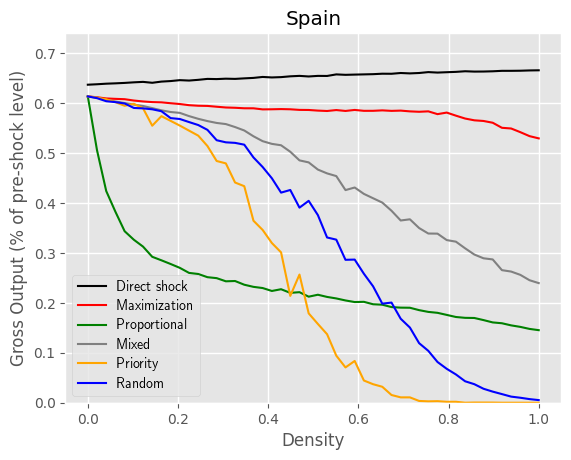

In [38]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.title("Spain")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(densseq, resdir_x, 'black')
plt.plot(densseq, resmax_x, 'red')
plt.plot(densseq, resprop_x, 'green')
plt.plot(densseq, resmixed_x, 'grey')
plt.plot(densseq, resprior_x, 'orange')
plt.plot(densseq, resrandom_x, 'blue')


#plt.xlim(-0.05, 1) 
plt.ylim(-0.00,0.74)
plt.rcParams['text.usetex'] = True
plt.xlabel('Density')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_esp_density.png')